In [1]:
import os
# force CPU for inference
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.models import load_model
import pandas as pd
import keras.backend as K
from keras.callbacks import LearningRateScheduler
from keras.callbacks import Callback
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
model = load_model('4_Block_Nets/FPV_ANN_tabulated_Standard_500.H5')
# model = load_model('../tmp/calc_100_3_3_cbrt.h5', custom_objects={'coeff_r2':coeff_r2})
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3)             0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 500)           2000        input_1[0][0]                    
____________________________________________________________________________________________________
res1a_branch2a (Dense)           (None, 500)           250500      dense_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 500)           0           res1a_branch2a[0][0]             
__________________

In [2]:
def read_h5_data(fileName, input_features, labels):
    df = pd.read_hdf(fileName)
#     df = df[df['f']<0.45]
#     for i in range(5):
#         pv_101=df[df['pv']==1]
#         pv_101['pv']=pv_101['pv']+0.002*(i+1)
#         df = pd.concat([df,pv_101])
    
    input_df=df[input_features]
    in_scaler = data_scaler()
    input_np = in_scaler.fit_transform(input_df.values,'std2')

    label_df=df[labels].clip(0)
#     if 'PVs' in labels:
#       label_df['PVs']=np.log(label_df['PVs']+1)
    out_scaler = data_scaler()
    label_np = out_scaler.fit_transform(label_df.values,'cbrt_std')

    return input_np, label_np, df, in_scaler, out_scaler

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class data_scaler(object):
    def __init__(self):
        self.norm = None
        self.norm_1 = None
        self.std = None
        self.case = None
        self.scale = 1
        self.bias = 1e-20
#         self.bias = 1


        self.switcher = {
            'min_std': 'min_std',
            'std2': 'std2',
            'std_min':'std_min',
            'min': 'min',
            'no':'no',
            'log': 'log',
            'log_min':'log_min',
            'log_std':'log_std',
            'log2': 'log2',
            'sqrt_std': 'sqrt_std',
            'cbrt_std': 'cbrt_std',
            'nrt_std':'nrt_std',
            'tan': 'tan'
        }

    def fit_transform(self, input_data, case):
        self.case = case
        if self.switcher.get(self.case) == 'min_std':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.norm.fit_transform(input_data)
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'std2':
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'min':
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = input_data

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'log_std':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'log2':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.norm.fit_transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'sqrt_std':
            out = np.sqrt(np.asarray(input_data / self.scale))
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'cbrt_std':
            out = np.cbrt(np.asarray(input_data / self.scale))
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'nrt_std':
            out = np.power(np.asarray(input_data / self.scale),1/4)
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'tan':
            self.norm = MaxAbsScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def transform(self, input_data):
        if self.switcher.get(self.case) == 'min_std':
            out = self.norm.transform(input_data)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'log_std':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'log2':
            out = self.norm.transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'sqrt_std':
            out = np.sqrt(np.asarray(input_data / self.scale))
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'cbrt_std':
            out = np.cbrt(np.asarray(input_data / self.scale))
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'nrt_std':
            out = np.power(np.asarray(input_data / self.scale),1/4)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'tan':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def inverse_transform(self, input_data):

        if self.switcher.get(self.case) == 'min_std':
            out = self.std.inverse_transform(input_data)
            out = self.norm.inverse_transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.norm.inverse_transform(input_data)
            out = self.std.inverse_transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log_min':
            out = self.norm.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log_std':
            out = self.std.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log2':
            out = self.std.inverse_transform(input_data)
            out = np.exp(out) - self.bias
            out = self.norm.inverse_transform(out)

        if self.switcher.get(self.case) == 'sqrt_std':
            out = self.std.inverse_transform(input_data)
            out = np.power(out,2) * self.scale

        if self.switcher.get(self.case) == 'cbrt_std':
            out = self.std.inverse_transform(input_data)
            out = np.power(out,3) * self.scale

        if self.switcher.get(self.case) == 'nrt_std':
            out = self.std.inverse_transform(input_data)
            out = np.power(out,4) * self.scale

        if self.switcher.get(self.case) == 'tan':
            out = (2 * np.pi + self.bias) * np.arctan(input_data)
            out = self.norm.inverse_transform(out)
            out = self.std.inverse_transform(out)

        return out

In [4]:
labels =  ['H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'CH3', 'CH4', 'CO', 'CO2', 'CH2O', 'N2', 'T', 'PVs']

print(labels)

input_features=['f','zeta','pv']

# read in the data
x_input, y_label, df, in_scaler, out_scaler = read_h5_data('data/tables_of_fgm.h5',input_features=input_features, labels = labels)

['H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'CH3', 'CH4', 'CO', 'CO2', 'CH2O', 'N2', 'T', 'PVs']


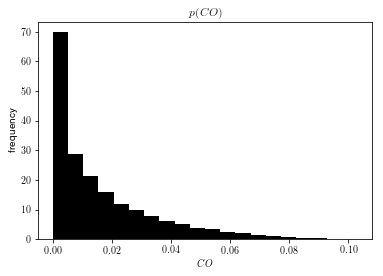

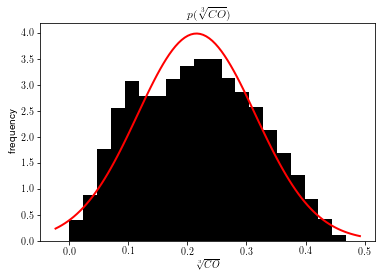

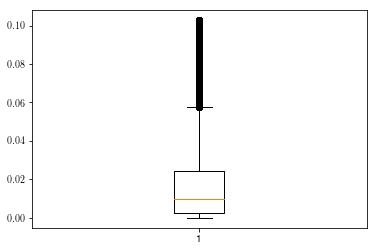

In [30]:
from scipy.stats import norm
import numpy as np

species_name = 'CO'

species = df[species_name]
species_cbrt = np.cbrt(species.values)

plt.hist(species,bins=20,normed=1,histtype='bar',color='k')
plt.xlabel(r'${%s}$' % species_name)
plt.ylabel('frequency')
plt.title('$p({%s})$' % species_name)

mu, std = norm.fit(species_cbrt)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
#plt.plot(x, p, 'r', linewidth=2)
plt.savefig('%s_hist.pdf' % species_name,format='pdf')


plt.show()


# 

plt.figure()
plt.hist(species_cbrt,bins=20,normed=1,histtype='bar',color='k')
plt.xlabel(r'$\sqrt[3]{{%s}}$' % species_name)
plt.ylabel('frequency')
plt.title('$p(\sqrt[3]{{%s}})$' % species_name)

# Plot the PDF.
mu, std = norm.fit(species_cbrt)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
plt.savefig('%s_cbrt_hist.pdf' % species_name,format='pdf')

plt.show()

# # # write the data for boxplot
# np.savetxt("%s.csv" % species_name, np.random.choice(species.values,500))
# np.savetxt("%s.csv" % species_name+'_cbrt', np.random.choice(species_cbrt,500))




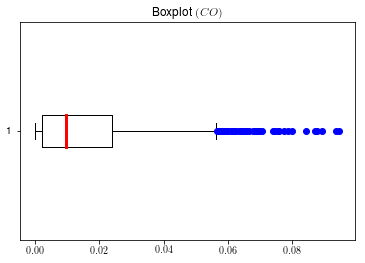

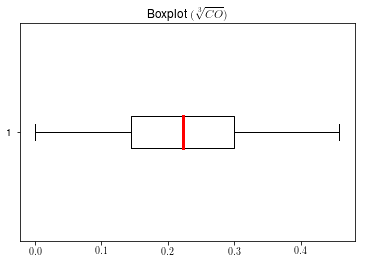

In [48]:
# BOXPLOT
plt.figure()
plt.boxplot(np.random.choice(species.values,1000),0, 'b', 0, medianprops= dict(linestyle='-', linewidth=3, color='red'))
plt.title('Boxplot $({%s})$' % species_name)
plt.savefig('%s_box.pdf' % species_name,format='pdf')

plt.figure()
plt.boxplot(np.random.choice(species_cbrt,1000),0, 'b', 0, medianprops= dict(linestyle='-', linewidth=3, color='red'))
plt.title('Boxplot $(\sqrt[3]{{%s}})$' % species_name)
plt.savefig('%s_cbrt_box.pdf' % species_name,format='pdf')

plt.show()



In [50]:
df.describe()



,zeta,f,pv,C2H,N2,AR,O2,H2O2,CH2OH,NH3,...,C3H7,HNO,CH2(S),PVs,H,NH,CH3CHO,C2H2,CH2O,T
count,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06,...,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06,2.510010e+06
mean,4.950000e-01,5.000000e-01,5.000000e-01,2.147784e-09,3.831254e-01,3.262333e-36,8.036380e-02,1.534944e-05,4.160802e-08,2.005331e-08,...,4.337298e-09,2.333144e-10,1.283290e-08,1.568056e+02,1.103071e-06,3.216369e-10,2.806265e-06,5.528403e-04,3.162843e-04,5.568075e+02
std,3.159510e-01,2.892520e-01,2.892520e-01,1.245209e-08,2.202126e-01,2.276408e-35,6.440376e-02,1.934027e-05,1.785011e-07,6.567947e-08,...,1.271907e-08,8.664397e-10,6.096944e-08,6.062716e+02,4.872116e-06,1.614583e-09,3.716432e-06,1.033583e-03,3.508757e-04,2.603179e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,-8.236060e-20,0.000000e+00,-2.196820e-39,0.000000e+00,0.000000e+00,-5.758230e-21,0.000000e+00,...,-2.128760e-14,-1.619010e-16,-3.693490e-27,-1.808280e-08,-4.238460e-19,-4.054210e-23,0.000000e+00,0.000000e+00,0.000000e+00,2.839370e+02
25%,2.200000e-01,2.500000e-01,2.500000e-01,1.109140e-16,1.929793e-01,3.337777e-42,2.431970e-02,1.097950e-06,4.124385e-12,1.667883e-10,...,9.033252e-11,9.908770e-15,1.134845e-13,1.603103e-01,3.669048e-10,3.826450e-15,3.387803e-07,4.036522e-05,3.877253e-05,3.450600e+02
50%,4.950000e-01,5.000000e-01,5.000000e-01,1.073640e-12,3.828640e-01,3.892380e-37,6.485325e-02,6.987800e-06,9.022295e-10,2.246675e-09,...,8.262370e-10,1.732465e-11,2.586045e-11,4.183725e+00,2.515815e-08,3.921125e-12,1.551995e-06,1.879045e-04,1.852960e-04,4.755145e+02
75%,7.700000e-01,7.500000e-01,7.500000e-01,1.305990e-10,5.731820e-01,2.925668e-36,1.269090e-01,2.296937e-05,1.277450e-08,2.005660e-08,...,3.580517e-09,1.780370e-10,2.771988e-09,6.467875e+01,3.584725e-07,1.138365e-10,4.004710e-06,5.839890e-04,4.812787e-04,6.900627e+02
max,9.900000e-01,1.000000e+00,1.000000e+00,7.894550e-07,7.670000e-01,2.284870e-33,2.330000e-01,1.089070e-04,7.575160e-06,4.648430e-06,...,4.461780e-07,4.437750e-08,2.899430e-06,2.153130e+04,2.939690e-04,1.181180e-07,6.329200e-05,1.561220e-02,1.811010e-03,2.230450e+03
